In [85]:
import warnings
warnings.filterwarnings('ignore')

In [204]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [111]:
from sklearn import svm 

In [192]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

### Read datasets

In [97]:
monks1_test = pd.read_csv('../data/monks-1.test', header=None, delimiter=' ')
monks1_train = pd.read_csv('../data/monks-1.train', header=None, delimiter=' ')
monks2_test = pd.read_csv('../data/monks-2.test', header=None, delimiter=' ')
monks2_train = pd.read_csv('../data/monks-2.train', header=None, delimiter=' ')
monks3_test = pd.read_csv('../data/monks-3.test', header=None, delimiter=' ')
monks3_train = pd.read_csv('../data/monks-3.train', header=None, delimiter=' ')

ml_cup22_train = pd.read_csv('../data/ML-CUP22-TR.csv', header=None)
ml_cup22_test = pd.read_csv('../data/ML-CUP22-TS.csv', header=None)

In [103]:
monks1_test.shape, monks1_train.shape, monks2_test.shape, monks2_train.shape, monks3_test.shape, monks3_train.shape, 

((432, 9), (124, 9), (432, 9), (169, 9), (432, 9), (122, 9))

### Preprocess monks sets

Attribute information:
* class: 0, 1 
* a1:    1, 2, 3
* a2:    1, 2, 3
* a3:    1, 2
* a4:    1, 2, 3
* a5:    1, 2, 3, 4
* a6:    1, 2
* Id:    (A unique symbol for each instance)

#### set 1

In [90]:
test1 = monks1_test.drop(columns=0)
columns = ['class', 'a1', 'a2', 'a3', 'a4', 'a4', 'a6', 'id']
test1.columns = columns
#test1.head()

In [91]:
train1 = monks1_train.drop(columns=0)
columns = ['class', 'a1', 'a2', 'a3', 'a4', 'a4', 'a6', 'id']
train1.columns = columns
#train1.head()

In [92]:
len(train1)/len(test1)

0.28703703703703703

In [93]:
print('test: ', test1['a1'].value_counts()) 
print('train: ', train1['a1'].value_counts())

test:  1    144
2    144
3    144
Name: a1, dtype: int64
train:  1    45
2    42
3    37
Name: a1, dtype: int64


#### set 2

In [98]:
test2 = monks2_test.drop(columns=0)
columns = ['class', 'a1', 'a2', 'a3', 'a4', 'a4', 'a6', 'id']
test2.columns = columns
train2 = monks2_train.drop(columns=0)
columns = ['class', 'a1', 'a2', 'a3', 'a4', 'a4', 'a6', 'id']
train2.columns = columns

#### set 3

In [104]:
test3 = monks3_test.drop(columns=0)
columns = ['class', 'a1', 'a2', 'a3', 'a4', 'a4', 'a6', 'id']
test3.columns = columns
train3 = monks3_train.drop(columns=0)
columns = ['class', 'a1', 'a2', 'a3', 'a4', 'a4', 'a6', 'id']
train3.columns = columns

### Prepare TRAIN and TEST sets

In [94]:
# Splitting the train set in X and y
X_train1 = train1.copy()
y_train1 = X_train1['class']
X_train1 = X_train1.drop(columns='id')
X_train1 = X_train1.drop(columns='class')
X_train1 = X_train1.values
# Splitting the test set in X and y
X_test1 = test1.copy()
y_test1 = X_test1['class']
X_test1 = X_test1.drop(columns='id')
X_test1 = X_test1.drop(columns='class')
X_test1 = X_test1.values

In [106]:
# Splitting the train set in X and y
X_train2 = train2.copy()
y_train2 = X_train2['class']
X_train2 = X_train2.drop(columns='id')
X_train2 = X_train2.drop(columns='class')
X_train2 = X_train2.values
# Splitting the test set in X and y
X_test2 = test2.copy()
y_test2 = X_test2['class']
X_test2 = X_test2.drop(columns='id')
X_test2 = X_test2.drop(columns='class')
X_test2 = X_test2.values

In [107]:
# Splitting the train set in X and y
X_train3 = train3.copy()
y_train3 = X_train3['class']
X_train3 = X_train3.drop(columns='id')
X_train3 = X_train3.drop(columns='class')
X_train3 = X_train3.values
# Splitting the test set in X and y
X_test3 = test3.copy()
y_test3 = X_test3['class']
X_test3 = X_test3.drop(columns='id')
X_test3 = X_test3.drop(columns='class')
X_test3 = X_test3.values

### 1. SVM

In [189]:
#Create a svm Classifier
clf = svm.SVC(random_state=42) # Linear Kernel

#Train the model using the train 1 set
clf.fit(X_train1, y_train1)

#Predict the response for test dataset
y_pred1 = clf.predict(X_test1)

print('Accuracy %s' % accuracy_score(y_test1, y_pred1))
print('F1-score %s' % f1_score(y_test1, y_pred1, average=None))
print(classification_report(y_test1, y_pred1))

Accuracy 0.8333333333333334
F1-score [0.84347826 0.82178218]
              precision    recall  f1-score   support

           0       0.80      0.90      0.84       216
           1       0.88      0.77      0.82       216

    accuracy                           0.83       432
   macro avg       0.84      0.83      0.83       432
weighted avg       0.84      0.83      0.83       432



In [190]:
#Train the model using the train 2 set
clf.fit(X_train2, y_train2)

#Predict the response for test dataset
y_pred2 = clf.predict(X_test2)

print('Accuracy %s' % accuracy_score(y_test2, y_pred2))
print('F1-score %s' % f1_score(y_test2, y_pred2, average=None))
print(classification_report(y_test2, y_pred2))

Accuracy 0.6805555555555556
F1-score [0.78504673 0.37837838]
              precision    recall  f1-score   support

           0       0.72      0.87      0.79       290
           1       0.53      0.30      0.38       142

    accuracy                           0.68       432
   macro avg       0.62      0.58      0.58       432
weighted avg       0.65      0.68      0.65       432



In [191]:
#Train the model using the train 3 set
clf.fit(X_train3, y_train3)

#Predict the response for test dataset
y_pred3 = clf.predict(X_test3)

print('Accuracy %s' % accuracy_score(y_test3, y_pred3))
print('F1-score %s' % f1_score(y_test3, y_pred3, average=None))
print(classification_report(y_test3, y_pred3))

Accuracy 0.9699074074074074
F1-score [0.96912114 0.97065463]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       204
           1       1.00      0.94      0.97       228

    accuracy                           0.97       432
   macro avg       0.97      0.97      0.97       432
weighted avg       0.97      0.97      0.97       432



In [136]:
## #Create a svm Classifier
## clf_linear = svm.LinearSVC() # Linear Kernel
## 
## #Train the model using the training sets
## clf_linear.fit(X_train1, y_train1)
## 
## #Predict the response for test dataset
## y_pred1_linear = clf_linear.predict(X_test1)

### Hyperparameter Tuning for SVM

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
#Create a svm Classifier
clf = svm.SVC(random_state=42)

# Grid Search
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear', 'rbf', 'poly']},
  #{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001]},
]

grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=20)
grid_search.fit(X_train1, y_train1)
grid_search.best_estimator_

SVC(C=100, kernel='poly', random_state=42)

In [197]:
#Create a svm Classifier
clf = svm.SVC(random_state=42)

# Grid Search
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear', 'rbf', 'poly']},
  #{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001]},
]

grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=20)
grid_search.fit(X_train1, y_train1)
clf = grid_search.best_estimator_

y_pred1 = clf.predict(X_test1)
#y_score1 = clf.predict_proba(X_test1)

print('Accuracy %s' % accuracy_score(y_test1, y_pred1))
print('F1-score %s' % f1_score(y_test1, y_pred1, average=None))
print(classification_report(y_test1, y_pred1))

Accuracy 0.9212962962962963
F1-score [0.92018779 0.92237443]
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       216
           1       0.91      0.94      0.92       216

    accuracy                           0.92       432
   macro avg       0.92      0.92      0.92       432
weighted avg       0.92      0.92      0.92       432



In [196]:
#Create a svm Classifier
clf = svm.SVC(random_state=42)

# Grid Search
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear', 'rbf', 'poly']},
  #{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001]},
]

grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=20)
grid_search.fit(X_train2, y_train2)
clf = grid_search.best_estimator_

y_pred2 = clf.predict(X_test2)
#y_score2 = clf.predict_proba(X_test2)

print('Accuracy %s' % accuracy_score(y_test2, y_pred2))
print('F1-score %s' % f1_score(y_test2, y_pred2, average=None))
print(classification_report(y_test2, y_pred2))

Accuracy 0.8125
F1-score [0.85245902 0.74285714]
              precision    recall  f1-score   support

           0       0.90      0.81      0.85       290
           1       0.68      0.82      0.74       142

    accuracy                           0.81       432
   macro avg       0.79      0.82      0.80       432
weighted avg       0.83      0.81      0.82       432



In [194]:
#Create a svm Classifier
clf = svm.SVC(random_state=42)

# Grid Search
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear', 'rbf', 'poly']},
  #{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001]},
]

grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=20)
grid_search.fit(X_train3, y_train3)
clf = grid_search.best_estimator_

y_pred3 = clf.predict(X_test3)
#y_score3 = clf.predict_proba(X_test3)

print('Accuracy %s' % accuracy_score(y_test3, y_pred3))
print('F1-score %s' % f1_score(y_test3, y_pred3, average=None))
print(classification_report(y_test3, y_pred3))

Accuracy 0.9328703703703703
F1-score [0.93176471 0.93394077]
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       204
           1       0.97      0.90      0.93       228

    accuracy                           0.93       432
   macro avg       0.93      0.93      0.93       432
weighted avg       0.94      0.93      0.93       432



### 2. SVM 

In [212]:
#Create a svm Classifier
clf = svm.LinearSVC(random_state=42)

# Grid Search
param_grid = [
  {'C': [1, 10, 100, 1000]},
  #{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001]},
]

grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=20)
grid_search.fit(X_train1, y_train1)
clf = grid_search.best_estimator_

y_pred1 = clf.predict(X_test1)
#y_score1 = clf.predict_proba(X_test1)

print('Accuracy %s' % accuracy_score(y_test1, y_pred1))
print('F1-score %s' % f1_score(y_test1, y_pred1, average=None))
print(classification_report(y_test1, y_pred1))

Accuracy 0.6666666666666666
F1-score [0.65876777 0.67420814]
              precision    recall  f1-score   support

           0       0.67      0.64      0.66       216
           1       0.66      0.69      0.67       216

    accuracy                           0.67       432
   macro avg       0.67      0.67      0.67       432
weighted avg       0.67      0.67      0.67       432



In [214]:
#Create a svm Classifier
clf = svm.LinearSVC(random_state=42)

# Grid Search
param_grid = [
  {'C': [1, 10, 100, 1000]},
  #{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001]},
]

grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=20)
grid_search.fit(X_train2, y_train2)
clf = grid_search.best_estimator_

y_pred2 = clf.predict(X_test2)

print('Accuracy %s' % accuracy_score(y_test2, y_pred2))
print('F1-score %s' % f1_score(y_test2, y_pred2, average=None))
print(classification_report(y_test2, y_pred2))

Accuracy 0.6412037037037037
F1-score [0.77239354 0.15300546]
              precision    recall  f1-score   support

           0       0.67      0.91      0.77       290
           1       0.34      0.10      0.15       142

    accuracy                           0.64       432
   macro avg       0.51      0.50      0.46       432
weighted avg       0.56      0.64      0.57       432



In [215]:
#Create a svm Classifier
clf = svm.LinearSVC(random_state=42)

# Grid Search
param_grid = [
  {'C': [1, 10, 100, 1000]},
  #{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001]},
]

grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=20)
grid_search.fit(X_train3, y_train3)
clf = grid_search.best_estimator_

y_pred3 = clf.predict(X_test3)

print('Accuracy %s' % accuracy_score(y_test3, y_pred3))
print('F1-score %s' % f1_score(y_test3, y_pred3, average=None))
print(classification_report(y_test3, y_pred3))

Accuracy 0.8379629629629629
F1-score [0.84090909 0.83490566]
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       204
           1       0.90      0.78      0.83       228

    accuracy                           0.84       432
   macro avg       0.84      0.84      0.84       432
weighted avg       0.85      0.84      0.84       432



### Model Evaluation

In [203]:
#from scikitplot.metrics import plot_roc
#from scikitplot.metrics import plot_precision_recall
#from scikitplot.metrics import plot_cumulative_gain
#from scikitplot.metrics import plot_lift_curve

#### Confusion Matrix

In [207]:
cf = confusion_matrix(y_test1, y_pred1)
cf

array([[196,  20],
       [ 14, 202]], dtype=int64)

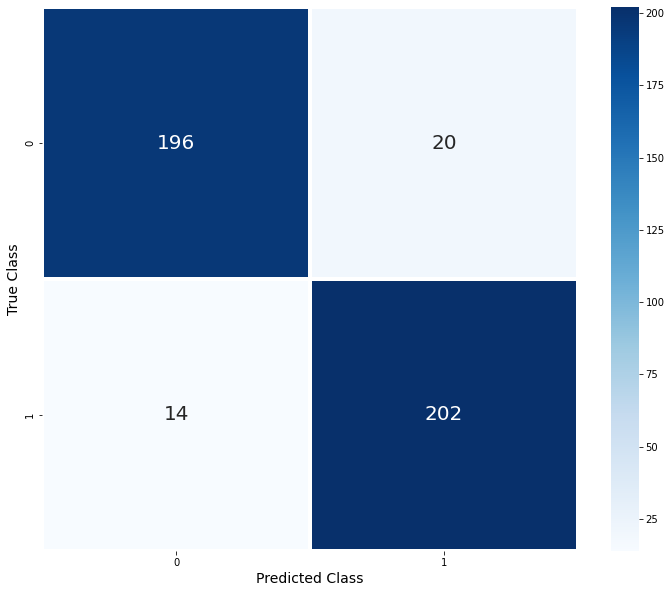

In [208]:
activities = ['0', '1']

ax = plt.subplots(figsize = (12,10))
ax = sns.heatmap(cf, annot=True, fmt="d", annot_kws={"size": 20}, linewidths=4, cmap="Blues")
ax.set_xticklabels(activities, fontsize=10)
ax.set_xlabel('Predicted Class', fontsize=14)
ax.set_yticklabels(activities, fontsize=10)
ax.set_ylabel('True Class', fontsize=14)

plt.show()